In [71]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import os

import matplotlib 
import matplotlib.pyplot as plt

import tensorflow as tf 
import keras 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau


from keras.datasets import mnist

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical 

import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# Cargamos el scaler que usamos para escalar los datos previamente

with open('escaladores/x_scaler.pickle', 'rb') as file:
    x_scaler = pickle.load(file)
    
with open('escaladores/y_scaler.pickle', 'rb') as file:
    y_scaler = pickle.load(file)

In [4]:
df = pd.read_csv("../bin/data_process.csv")

In [5]:
# Quitamos el precio nuevo porque a Miguel le parece que es hacer trampa

x = df.drop(columns = ['precio_contado', 'log_precio_nuevo'], axis=1)  
y = df['precio_contado']  

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=33)

In [67]:
# Definir un EarlyStopping para detener el entrenamiento si la pérdida no mejora

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose = 1)

In [101]:
reduce_lr = ReduceLROnPlateau(
    # Métrica a monitorear (generalmente 'val_loss')
    monitor='val_loss', 
    # Factor por el cual se reduce el learning rate (LR = LR * factor)
    factor=0.75, 
    # Número de épocas sin mejora antes de reducir el LR
    patience=4,  
    # Valor mínimo que puede alcanzar el learning rate
    min_lr=0.00001,      
    # Imprime mensajes cuando se reduce el LR
    verbose=1                  
)

In [30]:
def crear_modelo(input_dim = x_train.shape[1] , learning_rate=0.001, func_loss = 'mse'):
    """
    Crea una red neuronal para regresión.

    Parámetros:
    - input_dim (int): Número de características de entrada.
    - learning_rate (float): Tasa de aprendizaje para el optimizador Adam.
    - func_loss (str): Función de pérdida ('mse' o 'mae').

    Retorno:
    - model (keras.Sequential): Modelo compilado.
    """
    
    model = Sequential()
    
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))  
    
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2)) 
    
    model.add(Dense(1, activation='linear')) 
    
    optimizer = Adam(learning_rate=learning_rate)
    
    if func_loss == 'mse':
        model.compile(optimizer=optimizer, loss= 'mse' , metrics=['mean_absolute_error'])
        
    else:
        model.compile(optimizer=optimizer, loss= 'mae' , metrics=['mean_squared_error'])
    
    return model


In [103]:
def entrenamiento(modelo):
    """
    Entrena el modelo y devuelve un DataFrame con las métricas finales.
    También grafica la evolución de la pérdida durante el entrenamiento.

    Parámetros:
    - modelo: El modelo de red neuronal a entrenar.

    Retorna:
    - resultados: DataFrame con el número de épocas y las métricas finales (MSE y MAE).
    """
    initial_learning_rate = modelo.optimizer.learning_rate.numpy()
    
    history = modelo.fit(x_train, y_train, validation_data=(x_test, y_test), 
                    epochs=100, batch_size=32, callbacks=[early_stopping,reduce_lr], verbose=1)

    # Obtener el número de épocas que ha tardado en llegar al plateau
    epochs_run = len(history.history['loss'])

    # Obtener las métricas finales
    metrics = modelo.evaluate(x_test, y_test)

    resultados = pd.DataFrame({
        'Número de épocas': [epochs_run],
        'Pérdida final (MSE)': [metrics[0]],
        'MAE final': [metrics[1]]
    })
    
    loss_name = modelo.loss.upper()
    
    final_learning_rate = modelo.optimizer.learning_rate.numpy()
    
    plt.plot(history.history['loss'], label=f'{loss_name} (Training)')
    plt.plot(history.history['val_loss'], label=f'{loss_name} (Validation)')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    if initial_learning_rate == final_learning_rate:
        plt.title(f'Evolución de la pérdida durante el entrenamiento. Learning rate del {initial_learning_rate * 100:.2f}%')
        
    else: 
        plt.title(f'Evolución de la pérdida durante el entrenamiento. Learning rate inicial del {initial_learning_rate * 100:.2f}% y learning rate final de {final_learning_rate * 100:.2f}%')
    plt.show()
    
    return resultados

Epoch 1/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1999 - mean_absolute_error: 0.2847 - val_loss: 0.1056 - val_mean_absolute_error: 0.2128 - learning_rate: 0.0050
Epoch 2/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0770 - mean_absolute_error: 0.1810 - val_loss: 0.0294 - val_mean_absolute_error: 0.1127 - learning_rate: 0.0050
Epoch 3/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0681 - mean_absolute_error: 0.1684 - val_loss: 0.0222 - val_mean_absolute_error: 0.0932 - learning_rate: 0.0050
Epoch 4/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0616 - mean_absolute_error: 0.1632 - val_loss: 0.0201 - val_mean_absolute_error: 0.0850 - learning_rate: 0.0050
Epoch 5/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0582 - mean_absolute_error: 0.1606 - val_loss: 0.0173 - val_mean_absolute_error: 0.0791 - learning_rate: 0.0050
Epoch 6/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0563 - mean_absolute_error: 0.1557 - val_loss: 0.0196 - val_me

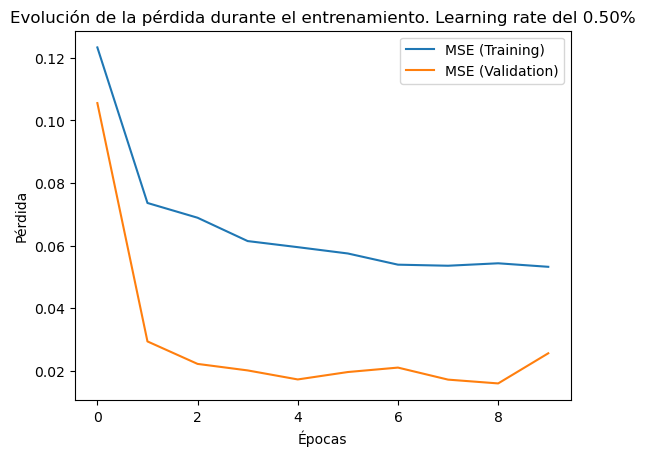

   Número de épocas  Pérdida final (MSE)  MAE final
0                10             0.105558   0.212801


In [105]:
neural_mse = crear_modelo(learning_rate= 0.005)

resultados_entrenamiento = entrenamiento(neural_mse)
print(resultados_entrenamiento)

Epoch 1/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2356 - mean_absolute_error: 0.3035 - val_loss: 0.0588 - val_mean_absolute_error: 0.1875 - learning_rate: 0.0030
Epoch 2/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0948 - mean_absolute_error: 0.1998 - val_loss: 0.0356 - val_mean_absolute_error: 0.1409 - learning_rate: 0.0030
Epoch 3/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0759 - mean_absolute_error: 0.1811 - val_loss: 0.0299 - val_mean_absolute_error: 0.1360 - learning_rate: 0.0030
Epoch 4/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0711 - mean_absolute_error: 0.1748 - val_loss: 0.0238 - val_mean_absolute_error: 0.1113 - learning_rate: 0.0030
Epoch 5/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0684 - mean_absolute_error: 0.1725 - val_loss: 0.0366 - val_mean_absolute_error: 0.1108 - learning_rate: 0.0030
Epoch 6/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0695 - mean_absolute_error: 0.1723 - val_loss: 0.0187 - val_me

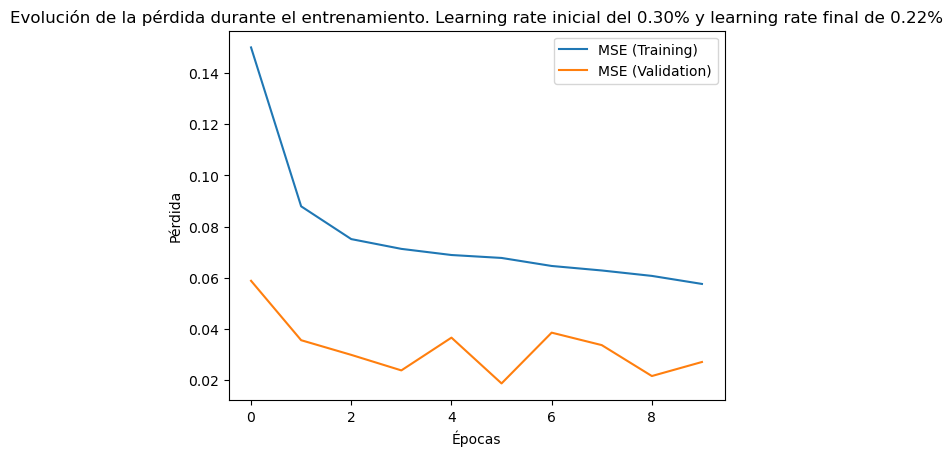

   Número de épocas  Pérdida final (MSE)  MAE final
0                10             0.058812    0.18753


In [106]:
neural_mse_2 = crear_modelo(learning_rate= 0.003)

resultados_entrenamiento = entrenamiento(neural_mse_2)
print(resultados_entrenamiento)

Epoch 1/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2004 - mean_absolute_error: 0.2889 - val_loss: 0.0462 - val_mean_absolute_error: 0.1538 - learning_rate: 0.0035
Epoch 2/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0919 - mean_absolute_error: 0.1954 - val_loss: 0.0372 - val_mean_absolute_error: 0.1427 - learning_rate: 0.0035
Epoch 3/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0738 - mean_absolute_error: 0.1769 - val_loss: 0.0163 - val_mean_absolute_error: 0.0895 - learning_rate: 0.0035
Epoch 4/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0697 - mean_absolute_error: 0.1734 - val_loss: 0.0482 - val_mean_absolute_error: 0.1220 - learning_rate: 0.0035
Epoch 5/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0614 - mean_absolute_error: 0.1680 - val_loss: 0.0387 - val_mean_absolute_error: 0.1400 - learning_rate: 0.0035
Epoch 6/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0628 - mean_absolute_error: 0.1656 - val_loss: 0.0259 - val_me

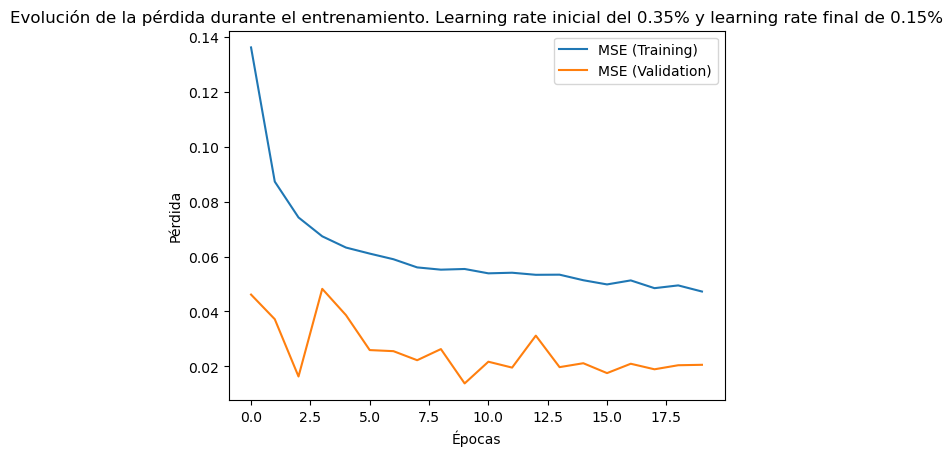

   Número de épocas  Pérdida final (MSE)  MAE final
0                20             0.013754   0.074647


In [107]:
neural_mse_3 = crear_modelo(learning_rate= 0.0035)

resultados_entrenamiento = entrenamiento(neural_mse_3)
print(resultados_entrenamiento)

In [116]:
neural_mse_3.save('modelo/red_neuronal.keras')

## Predicciones para streamlit

In [ ]:
# Suponiendo que `x_new` son los datos nuevos para los que quieres predecir
x_new_scaled = x_scaler.transform(x_new)  # Escalar los datos de entrada

# Hacer la predicción
y_pred_scaled = modelo.predict(x_new_scaled)

# Desescalar la predicción
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

print("Predicción en escala original:", y_pred)

In [ ]:
import streamlit as st
import numpy as np
from tensorflow.keras.models import load_model

# Cargar el modelo
modelo = load_model('modelo/red_neuronal.keras')

# Título de la aplicación
st.title('Predicción con Red Neuronal')

# Crear entradas para las características
st.sidebar.header('Parámetros de entrada')
input_1 = st.sidebar.number_input('Característica 1', value=0.0)
input_2 = st.sidebar.number_input('Característica 2', value=0.0)
input_3 = st.sidebar.number_input('Característica 3', value=0.0)

# Botón para predecir
if st.sidebar.button('Predecir'):
    # Convertir los inputs en un array para el modelo
    entrada = np.array([[input_1, input_2, input_3]])  # Cambia según tus características
    prediccion = modelo.predict(entrada)
    st.write(f'La predicción del modelo es: {prediccion[0][0]:.2f}')


## Pruebas

In [101]:
model_mse = Sequential()
model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

optimizer = Adam(learning_rate=0.001)
model_mse.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [103]:
history_mse = model_mse.fit(x_train, y_train, validation_data=(x_test, y_test), 
                    epochs=100, batch_size=32, callbacks=[early_stopping], verbose=1)

# Obtener el número de épocas que ha tardado en llegar al plateau
epochs_run = len(history_mse.history['loss'])

# Obtener las métricas finales
metrics_mse = model_mse.evaluate(x_test, y_test)

resultados_mse = pd.DataFrame({
    'Número de épocas': [epochs_run],
    'Pérdida final (MSE)': [metrics_mse[0]],
    'MAE final': [metrics_mse[1]]
})

Epoch 1/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 16542309206196224.0000 - mean_absolute_error: 45484524.0000 - val_loss: 631466.1250 - val_mean_absolute_error: 761.3967
Epoch 2/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 632544.5000 - mean_absolute_error: 756.8943 - val_loss: 617849.5000 - val_mean_absolute_error: 748.9711
Epoch 3/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 627081.9375 - mean_absolute_error: 747.2271 - val_loss: 612672.2500 - val_mean_absolute_error: 748.1154
Epoch 4/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 700053.6875 - mean_absolute_error: 766.5193 - val_loss: 641954.4375 - val_mean_absolute_error: 766.0994
Epoch 5/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 777398.1875 - mean_absolute_error: 791.0446 - val_loss: 833823.8125 - val_mean_absolute_error: 773.0881
Epoch 6/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1347914.5000 - mean_absolute_error: 942.8879 - val_loss: 1931687.2500 - val_mean_absolute_error: 1

In [104]:
resultados_mse

,Número de épocas,Pérdida final (MSE),MAE final
0,39,122158.078125,278.400726


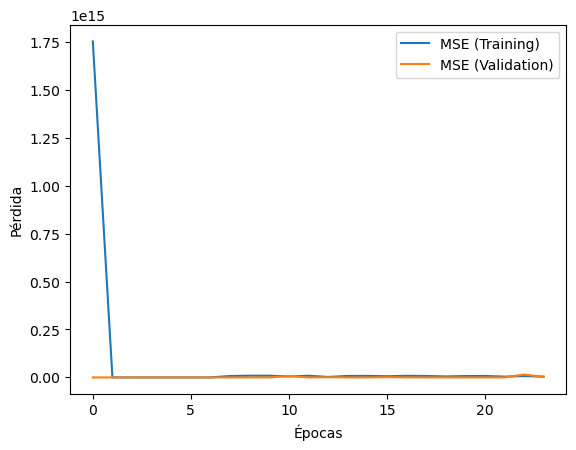

In [97]:
plt.plot(history_mse.history['loss'], label='MSE (Training)')
plt.plot(history_mse.history['val_loss'], label='MSE (Validation)')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [83]:
model_mae = Sequential()
model_mae.add(Input(shape=(x_train.shape[1],)))
model_mae.add(Dense(64, activation='relu'))
model_mae.add(Dense(1))
model_mae.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_squared_error'])

# Configurar EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Entrenar el modelo con la pérdida MAE
history_mae = model_mae.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=100, batch_size=32,
    callbacks=[early_stopping], verbose=1
)

# Obtener el número de épocas que ha tardado en llegar al plateau
epochs_run_mae = len(history_mae.history['loss'])

# Obtener las métricas finales
metrics_mae = model_mae.evaluate(x_test, y_test)

# Guardar los resultados en un DataFrame
resultados_mae = pd.DataFrame({
    'Número de épocas': [epochs_run_mae],
    'Pérdida final (MAE)': [metrics_mae[0]],
    'MSE final': [metrics_mae[1]]
})

Epoch 1/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 96911096.0000 - mean_squared_error: 70857455621373952.0000 - val_loss: 21568416.0000 - val_mean_squared_error: 471555968598016.0000
Epoch 2/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 16937180.0000 - mean_squared_error: 511001518669824.0000 - val_loss: 16192176.0000 - val_mean_squared_error: 265770982440960.0000
Epoch 3/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 16356486.0000 - mean_squared_error: 435278225342464.0000 - val_loss: 18563278.0000 - val_mean_squared_error: 349305663651840.0000
Epoch 4/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 18366304.0000 - mean_squared_error: 526132118028288.0000 - val_loss: 3160053.5000 - val_mean_squared_error: 10122399055872.0000
Epoch 5/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 20595250.0000 - mean_squared_error: 707995293974528.0000 - val_loss: 182841.6250 - val_mean_squared_error: 33887074304.0000
Epoch 6/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/ste

In [85]:
resultados_mae

,Número de épocas,Pérdida final (MAE),MSE final
0,20,182841.625,3.388707e+10


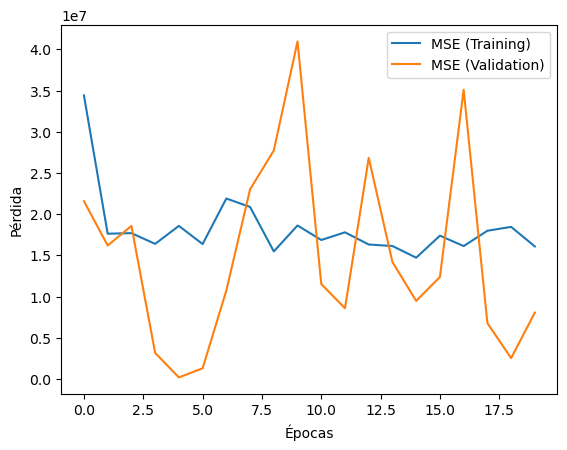

In [87]:
plt.plot(history_mae.history['loss'], label='MSE (Training)')
plt.plot(history_mae.history['val_loss'], label='MSE (Validation)')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
model_mae = Sequential()
model_mae.add(Input(shape=(x_train.shape[1],)))
model_mae.add(Dense(64, activation='relu'))
model_mae.add(Dense(1))
model_mae.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_squared_error'])

# Configurar EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo con la pérdida MAE
history_mae = model_mae.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=100, batch_size=32,
    callbacks=[early_stopping], verbose=1
)

# Obtener el número de épocas que ha tardado en llegar al plateau
epochs_run_mae = len(history_mae.history['loss'])

y_pred_mae = model_mae.predict(x_test)
y_pred_unscaled_mae = y_scaler.inverse_transform(np.array(y_pred_mae).reshape(-1, 1)).ravel()
y_test_unscaled_mae = y_scaler.inverse_transform(np.array(y_test).reshape(-1, 1)).ravel()
    
y_pred_original_mae = np.exp(y_pred_unscaled_mae)
y_test_original_mae = np.exp(y_test_unscaled_mae)
    
mae = mean_absolute_error(y_test_original_mae, y_pred_original_mae)
mse = mean_squared_error(y_test_original_mae, y_pred_original_mae)
r2 = r2_score(y_test_original_mae, y_pred_original_mae)

resultados_mae = pd.DataFrame({
    'Número de épocas': [epochs_run_mae],
    'Pérdida final (MAE)': [mae],
    'MSE final': [mse],
    'R² final': [r2]
})